In [1]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit import *
#from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_nature.second_q.drivers import PySCFDriver
#from qiskit.circuit.library import EfficientSU2
#from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.primitives import Estimator
#from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
molecule = "H .0 .0 .0; H .0 .0 0.739"
distances=np.arange(0.5,4.25,0.25)

In [3]:
for i,d in enumerate(distances):
    print('step', i)
    #setup my experiment
    driver=PySCFDriver(molecule.format(d/2),basis='sto3g')
    qmolecule = driver.run()
    #print(problem.num_particles)
    hamiltonian = qmolecule.hamiltonian
    coefficients = hamiltonian.electronic_integrals
    print(coefficients.alpha)
    # Generate the second-quantized operators
    hamiltonian = qmolecule.hamiltonian.second_q_op()
    second_q_ops = qmolecule.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]

step 0
Polynomial Tensor
 "+-":
array([[-1.25391476e+00, -4.25326005e-16],
       [-2.40547956e-16, -4.74438097e-01]])
 "++--":
array([6.74946763e-01, 6.24500451e-17, 1.81154541e-01, 6.63885295e-01,
       3.60822483e-16, 6.97835732e-01])
step 1
Polynomial Tensor
 "+-":
array([[-1.25391476e+00, -4.25326005e-16],
       [-2.40547956e-16, -4.74438097e-01]])
 "++--":
array([6.74946763e-01, 6.24500451e-17, 1.81154541e-01, 6.63885295e-01,
       3.60822483e-16, 6.97835732e-01])
step 2
Polynomial Tensor
 "+-":
array([[-1.25391476e+00, -4.25326005e-16],
       [-2.40547956e-16, -4.74438097e-01]])
 "++--":
array([6.74946763e-01, 6.24500451e-17, 1.81154541e-01, 6.63885295e-01,
       3.60822483e-16, 6.97835732e-01])
step 3
Polynomial Tensor
 "+-":
array([[-1.25391476e+00, -4.25326005e-16],
       [-2.40547956e-16, -4.74438097e-01]])
 "++--":
array([6.74946763e-01, 6.24500451e-17, 1.81154541e-01, 6.63885295e-01,
       3.60822483e-16, 6.97835732e-01])
step 4
Polynomial Tensor
 "+-":
array([[-1.2

In [4]:
from qiskit_nature.second_q.mappers import ParityMapper, BravyiKitaevMapper, JordanWignerMapper, QubitMapper, InterleavedQubitMapper

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = InterleavedQubitMapper(mapper)

# The fermionic operators are mapped to qubit operators

#qubit_op = converter.two_qubit_reduction(main_op, num_particles)
qubit_op = converter.map(hamiltonian)

In [5]:
from qiskit_nature.second_q.circuit.library import HartreeFock

num_particles = qmolecule.num_particles
num_spin_orbitals = qmolecule.num_spatial_orbitals * 2
init_state = HartreeFock(num_spin_orbitals,num_particles,converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          
q_6: ─────
          
q_7: ─────
          


## VQE

In [6]:
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50

    print(qmolecule.num_particles)
    # print(problem.num_parameters)
    print(qmolecule.num_spatial_orbitals)

    transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
    transformed_problem = transformer.transform(qmolecule)
    print(transformed_problem.num_particles)
    print(transformed_problem.num_spatial_orbitals)

    mapper = JordanWignerMapper()

    ansatz = UCCSD(
    transformed_problem.num_spatial_orbitals,
    transformed_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        transformed_problem.num_spatial_orbitals,
        transformed_problem.num_particles,
        mapper,
        ),
    )

    counts = []
    values = []

    def iteration_value(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

        
    vqe = VQE(Estimator(), ansatz, optimizer, callback=iteration_value)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

    #vqe_solver = VQE(Estimator(), ansatz, optimizers, callback=iteration_value)
    #vqe_solver.initial_point = [0.0] * ansatz.num_parameters
print("\rOptimization complete      ");

Optimizer: COBYLA        (1, 1)
2
(1, 1)
2
Optimizer: L_BFGS_B        (1, 1)
2
(1, 1)
2
Optimizer: SLSQP        (1, 1)
2
(1, 1)
2
Optimization complete      


In [7]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(qubit_op)
ref_value = result.eigenvalue.real

In [8]:
print(f"VQE value: {vqe_result:.5f}")
print(f"Reference value: {ref_value:.5f}")

VQE value: -1.24562
Reference value: -1.85336


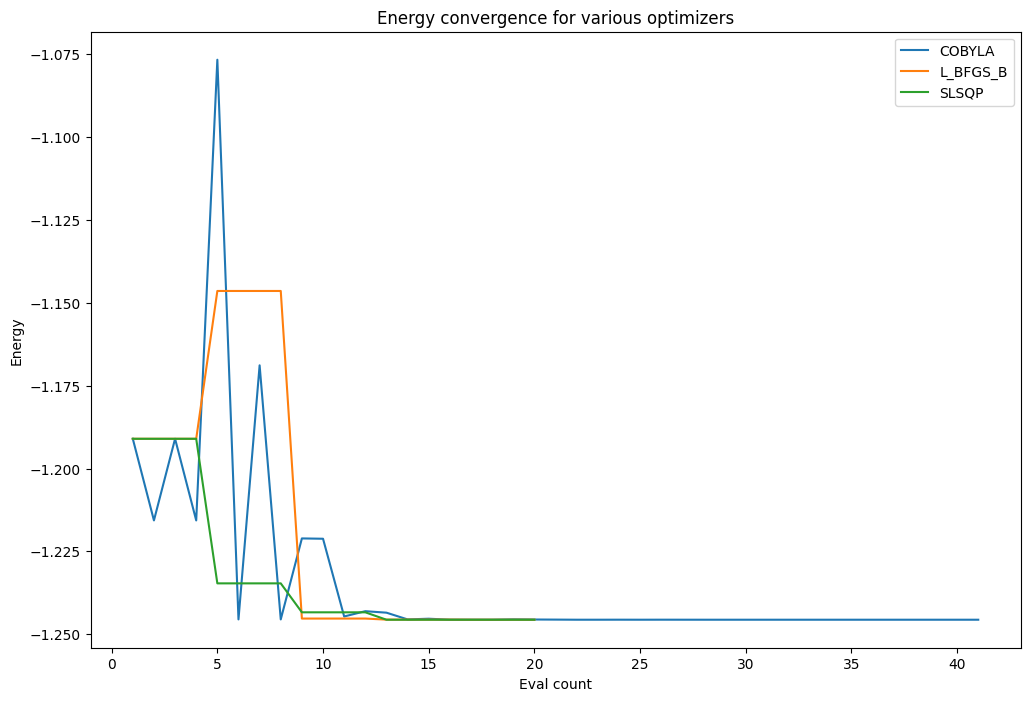

In [9]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");


In [10]:
import qiskit

qiskit.version.get_version_info()

'1.0.0'